# Presentation
---

Le but de cet exercice est de nous familiariser avec la manipulation de données. Pour ce faire, nous allons commencer par analyser une base de données de critiques tripadvisor pour ensuite faire de la prédiction de notes données par les clients. Le jeu de données peut être récupéré à [l'adresse suivante.](https://www.kaggle.com/datasets/andrewmvd/trip-advisor-hotel-reviews/data).

## Import des librairies

In [1]:
import ast
from bertopic import BERTopic
from collections import Counter
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora import Dictionary
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Dropout, MaxPooling1D, Flatten
from keras.losses import MeanAbsoluteError, MeanSquaredError
from keras.models import Sequential
from langdetect import detect
import matplotlib.pyplot as plt
import nltk
from nltk import ngrams
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import numpy as np
import pandas as pd
import pickle
import plotly.express as px
import plotly.graph_objects as go
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, silhouette_score
from sklearn.model_selection import train_test_split
from textblob import TextBlob
from time import time
import torch
from transformers import pipeline
from wordcloud import WordCloud, STOPWORDS

In [2]:
# Download nltk components
nltk.download("punkt")
nltk.download('stopwords')

pipe = pipeline("text-classification", model="nlptown/bert-base-multilingual-uncased-sentiment")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ClémentLION\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ClémentLION\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Chargement des données

In [3]:
reviews = pd.read_csv("data/tripadvisor_hotel_reviews.csv")

# Partie 1) Etude de la qualité des données

---

1) De combien de données disposons-nous ? 
2) Possédons-nous des données manquantes ou des doublons ? 
3) Est-ce nous possédons des commentaires en doubles ? Qu'en faire ?
3) Quelles sont les longueurs de nos commentaires ?
3) Dans quelles langues se trouvent nos données ?

In [7]:
print(f"Notre dataset contient {len(reviews)} lignes et {len(reviews.columns)} colonnes.")

Notre dataset contient 20491 lignes et 2 colonnes.


In [8]:
# Nous ne semblons pas avoir de données manquantes.
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  20491 non-null  object
 1   Rating  20491 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 320.3+ KB


In [11]:
# Vérifions si nous possédons des doublons dans nos données
print(f"Dans nos données, nous disposons de {sum(reviews['Review'].apply(lambda x : x.lower()).duplicated())} doublons.")

Dans nos données, nous disposons de 0 doublons.


In [12]:
# Vérifions que nous possédons du contenu dans nos critiques (et pas juste deux mots)
reviews["review_length"] = reviews["Review"].apply(len)

# Nous disposons de plusieurs valeurs extrêmes dans la longueur.
# Nous éliminons ces valeurs extrêmes avant de tracer l'histogramme de la longueur de nos critiques.
fig = px.histogram(reviews.loc[reviews["review_length"] < 4000], x="review_length", title = "Repartition of the text length of our reviews", nbins=50)
fig.show()

In [13]:
# On vérifie les longueurs de nos critiques.
# Warning : La détection de la langue est assez mauvaise pour les textes courts.
# Warning 2 : La cellule prend deux minutes à run.

def identify_language(x):
    try:
        return(detect(x))
    except:
        return("language_error")

reviews["text_language"] = reviews["Review"].apply(identify_language)

In [14]:
# Note : Certains commentaires sont indiqués comme n'étant pas en anglais.
reviews.groupby("text_language")["Review"].count()

text_language
af        4
en    20473
es        1
fr        7
it        2
nl        2
ro        2
Name: Review, dtype: int64

In [15]:
# Nous constatons que deux critiques sont en français. Afin d'éviter des problèmes plus tard, nous nous en débarassons.
# Il est amusant de constater que les mots classifiés comme étant français possèdent le mot excellent.
reviews.loc[reviews["text_language"] != "en"]

Review  Rating  \
140    rudest people dont stay, despite fact cool hot...       1   
1642   good value good value money, suggest getting r...       4   
4469   little gem lovely little hotel roman artifacts...       5   
6851   excellence excellent just retruned delightful ...       5   
8043   attitude love space receptionist rude abrupt, ...       2   
8205   not good aware not 4 star hotel, stayed week d...       2   
8532   loved calzaiouli just returned wonderful 10 da...       5   
8915   excellent location rooms adults, room quite sm...       5   
10804  excellent service location nice hotel, quiet, ...       5   
14397  sparkle ritz carlton chandeliers potzdamer pla...       5   
14932  excellent excellent excellent.., stayed nights...       5   
16240  eh, no didnt like room hotel super small does ...       2   
16426  excellent service convenient location come, pl...       5   
17264  une trappe touristes 4* ne pas approcher des b...       3   
18859  hotel unique moment inoubliable lieu hors du t...       5   
19840  best value london, bit far central london amaz...       5   
19884  great hotel, great time room mate laura hotel,...       5   
19936  just like good friend home friend went bali ja...       5   

       review_length text_language  
140              160            fr  
1642              92            af  
4469             118            fr  
6851             165            es  
8043              75            ro  
8205             106            af  
8532             341            it  
8915             207            fr  
10804            118            fr  
14397            115            nl  
14932            116            fr  
16240            113            af  
16426             93            it  
17264            120            fr  
18859            118            fr  
19840            125            nl  
19884             98            ro  
19936            246            af

In [16]:
dreviews = reviews.drop(index = [17264, 18859])

**Conclusion partie 1**: Nous disposons d'un bon nombre de lignes et nos commentaires semblent relativement long. Nous sommes confiants dans le fait que nous pouvons faire des analyses.

# Partie 2) Analyse

---

1) Analysez la distribution des notes. Qu'est-ce que cela présage pour la partie machine learning ?
2) Faire un wordcloud pour indiquer les mots les plus populaires dans nos différents commentaires en fonction de la note attribuée à la fin.
3) Faire la même chose que la question précédente mais avec du stemming au préalable (nous vous conseillons d'utiliser porterstemmer pour plus de facilité).
4) Faire la même chose que la question précédente mais cette fois-ci en considérant les groupes de deux mots adjacents (note culturelle : les groupes de k mots adjacents sont appelés k-grams)
5) Nous décidons qu'il serait bien de connaître un poil mieux nos utilisateurs. Afin de pouvoir en savoir plus, utilisons de la LDA afin de pouvoir trouver des thèmes dans nos commentaires d'utilisateurs. 

Note : afin d'étudier plus en détail les thèmes, nous aurions pu utiliser du bertopic qui nous aurait renvoyé des thèmes pertinents.

In [19]:
# Question 1
# Analyse des catagories présentes dans notre dataset
# Il semblerait que nos catégories ne soient pas équitablement distribuées. 

count_per_grade = reviews.groupby("Rating")["Review"].count()

fig = go.Figure()
fig.add_trace(go.Bar(x = count_per_grade.index, y = count_per_grade.values, text = count_per_grade.values, name = "Répartition des notes utilisateurs dans notre dataset"))
fig.update_layout(title=f"Répartition des notes utilisateurs dans notre dataset", xaxis_title=f"Note", yaxis_title="Nombre de lignes")
fig.show()

Notre jeu de données ne possède pas des données équilibrées. Nous avons un biais et nous devrons faire en sorte de la gérer au moment de la partie deep learning. Notamment, il nous faudra pondérer chacune des différentes catégories.

Main words used to talk about hotels when the rating = 1.


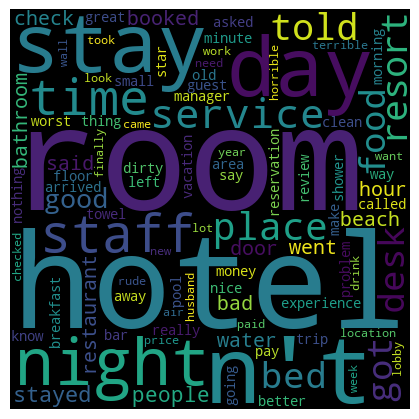

Main words used to talk about hotels when the rating = 2.


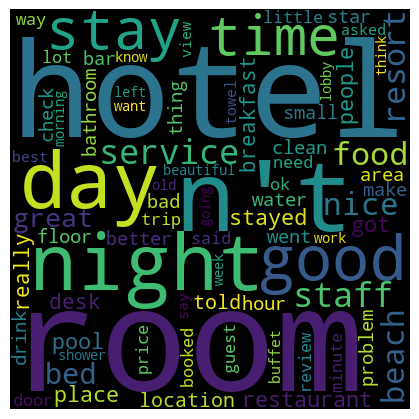

Main words used to talk about hotels when the rating = 3.


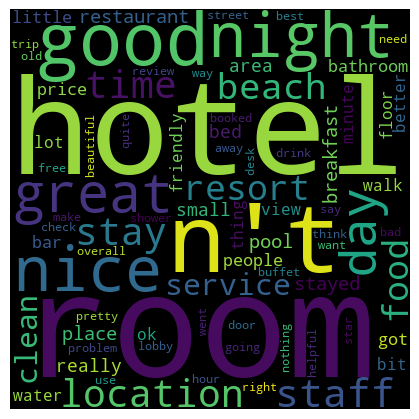

Main words used to talk about hotels when the rating = 4.


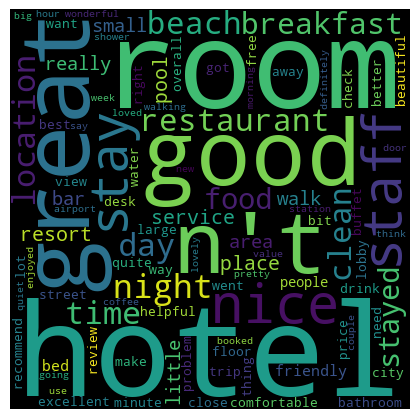

Main words used to talk about hotels when the rating = 5.


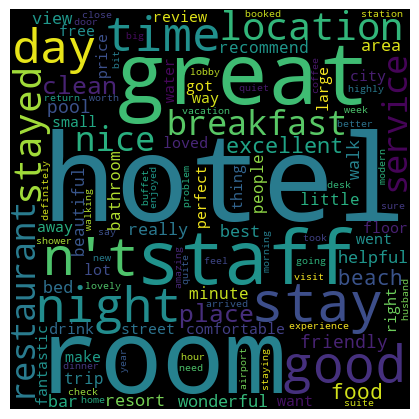

In [20]:
# Question 2)

# Elimination des stopwords
stop_words = set(STOPWORDS)

# Pour chacune des nos catégories de notes, nous récuoérons le texte, éliminons les stopwords et traçons notre wordcloud.
for k in range(1,6):
    study_group = reviews.loc[reviews["Rating"] == k]
    review_text = " ".join(study_group["Review"].values)

    # Wordcloud
    wordcloud = WordCloud(width = 400, height = 400,
                background_color ='black',
                stopwords = stop_words,
                min_font_size = 10,
                collocations=False).generate(review_text)
    
    print(f"Main words used to talk about hotels when the rating = {k}.")
    plt.figure(figsize = (4, 4), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    
    plt.show()

En regardant notre wordcloud, nous nous rendons compte de deux choses : d'une part, nous n'avons pas de différences notables dans les mots évoqués pour parler des différentes catégories et d'autre part, certains mots pourraient être groupés (comme c'est le cas pour stay et staying).

In [21]:
# Question 3)

# Mettons en place une étape de stemming
ps = PorterStemmer()

reviews["review_text_no_punkt"] = reviews["Review"].apply(lambda x : x.lower().replace("\n", " ").replace(",", "").replace(".", "").replace("!", "").replace("?", ""))
reviews["review_tokenized"] = reviews["review_text_no_punkt"].apply(word_tokenize)
# Note : Nous utilisons une liste de stopwords auquelle nous ajoutons quelques mots en plus.
stop_words = set(stopwords.words('english') + ["n't", "hotel", "room"])
reviews["review_text_stem"] = reviews["review_tokenized"].apply(lambda x : " ".join([ps.stem(word) for word in x if len(word) < 100 and word.lower() not in stop_words]))

Main words used to talk about hotels when the rating = 1.


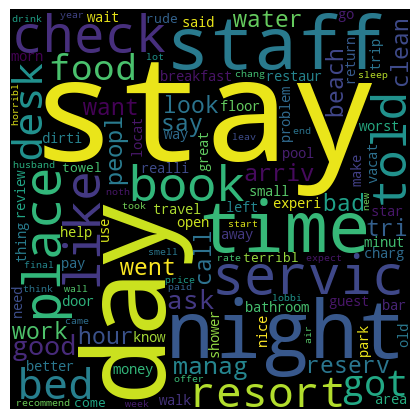

Main words used to talk about hotels when the rating = 2.


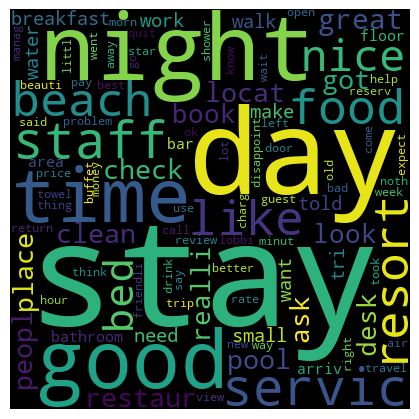

Main words used to talk about hotels when the rating = 3.


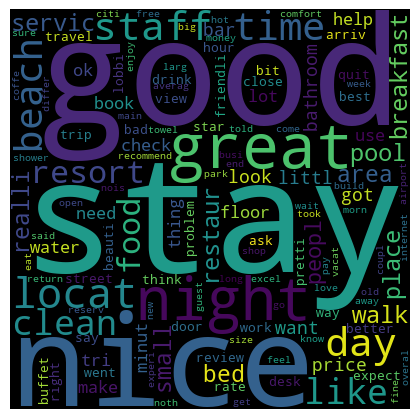

Main words used to talk about hotels when the rating = 4.


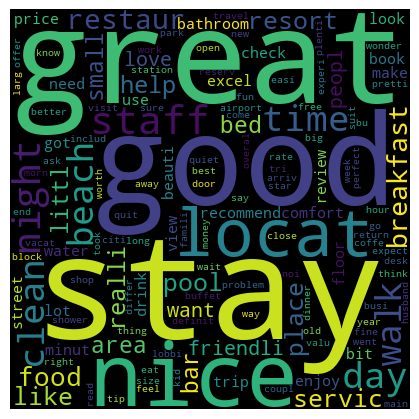

Main words used to talk about hotels when the rating = 5.


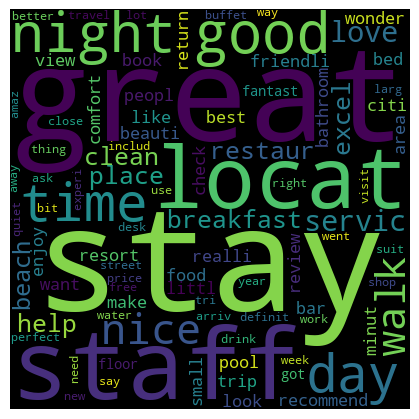

In [22]:
# Même chose que tout à l'heure

for k in range(1,6):
    study_group = reviews.loc[reviews["Rating"] == k]
    review_text = " ".join(study_group["review_text_stem"].values)

    # Wordcloud
    wordcloud = WordCloud(width = 400, height = 400,
                background_color ='black',
                stopwords = stop_words,
                min_font_size = 10,
                collocations=False).generate(review_text)
    
    print(f"Main words used to talk about hotels when the rating = {k}.")
    plt.figure(figsize = (4, 4), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    
    plt.show()

Nous voyons les choses légèrement plus clair. Nous nous disons que rien qu'en regardant si les mots "good" et "great" sont dans les avis, on pourrait sans doute avoir une prédiction correcte. Malheureusement, d'un point de vue analyste, nous ne comprenons pas trop ce qui se passe. Est-ce que les k-grams peuvent nous aider ?

In [32]:
# Question 4) Nous utilisons une méthode pour séparer les groupes de k mots successifs.
def generate_ngrams(tokens_list, n):
    ngrams_list = ngrams(tokens_list, n)
    ngrams_counts = Counter(ngrams_list)
    return ngrams_counts

reviews['bigrams'] = reviews['review_tokenized'].apply(lambda x: generate_ngrams(x, 2))

Main words used to talk about hotels when the rating = 1.


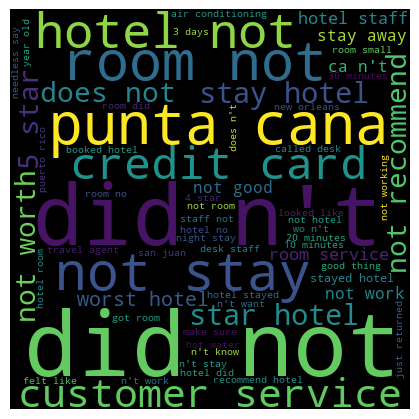

Main words used to talk about hotels when the rating = 2.


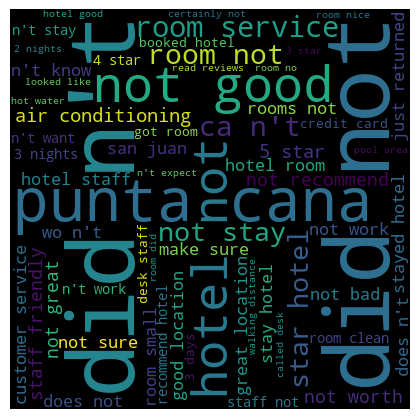

Main words used to talk about hotels when the rating = 3.


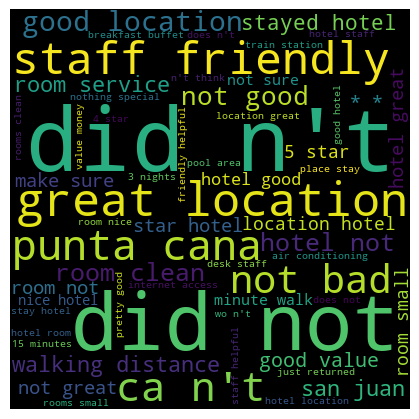

Main words used to talk about hotels when the rating = 4.


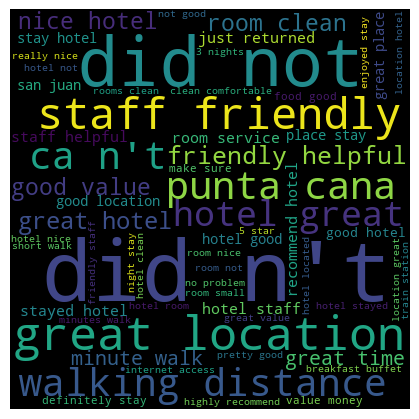

Main words used to talk about hotels when the rating = 5.


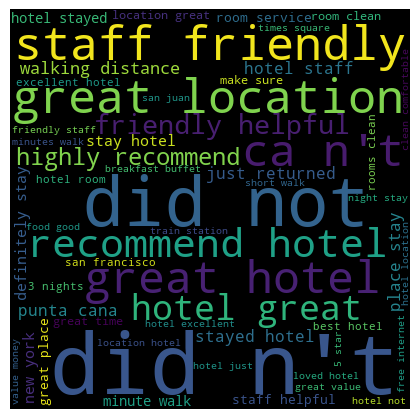

In [49]:
# Pour chacune des nos catégories de notes, nous récuoérons nos bigrams les plus populaires
for k in range(1,6):
    study_group = reviews.loc[reviews["Rating"] == k]
    # On initialise un objet counter et on le fait compter les différents bigrams
    bigram_counts = Counter()
    for bigram_counter in study_group['bigrams']:
        bigram_counts.update(bigram_counter)

    dict_bigrams = {" ".join(my_key) : my_value for my_key, my_value in bigram_counts.items()}
    # On crée ensuite notre wordcloud
    wordcloud = WordCloud(width = 400, height = 400,
                background_color ='black',
                min_font_size = 10,
                collocations=False).generate_from_frequencies(dict_bigrams)
    
    print(f"Main words used to talk about hotels when the rating = {k}.")
    plt.figure(figsize = (4, 4), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    
    plt.show()

In [51]:
# Question 5) Nous voulons utiliser du LDA. Le LDA est une méthode d'apprentissage non supervisée qui identifie des thèmes comme étant une équation sur les mots.
# On indique à la LDA combien de thèmes on veut étudier et on la laisse élaborer ses équations.
# Limitation connue : on ne tient pas compte du contexte environnant les mots. On peut faire en sorte qu'on ait une équation sur des bigrams.
# Attention prend du temps.

# on exclue les mots trop rares.
cv = CountVectorizer(max_df=0.90, min_df=2)
base_de_mots = cv.fit_transform(reviews["review_text_stem"])

lda = LatentDirichletAllocation(n_components=7, random_state=42)
lda.fit(base_de_mots)

LatentDirichletAllocation(n_components=7, random_state=42)

In [52]:
# On essaie ensuite de retrouver les thèmes en regardant les mots qui les composent.
n = 5
for index, topic in enumerate(lda.components_):
    print(f'Mots utilisés pour le sujet n°{index}')
    print([cv.get_feature_names_out()[i] for i in topic.argsort()[-n:]])

Mots utilisés pour le sujet n°0
['food', 'restaur', 'stay', 'staff', 'servic']
Mots utilisés pour le sujet n°1
['room', 'desk', 'check', 'night', 'stay']
Mots utilisés pour le sujet n°2
['staff', 'nice', 'locat', 'great', 'stay']
Mots utilisés pour le sujet n°3
['time', 'food', 'peopl', 'day', 'resort']
Mots utilisés pour le sujet n°4
['good', 'resort', 'pool', 'great', 'beach']
Mots utilisés pour le sujet n°5
['room', 'price', 'view', 'star', 'good']
Mots utilisés pour le sujet n°6
['walk', 'great', 'good', 'stay', 'locat']


In [62]:
# Un des problèmes de la LDA est qu'on ne connait pas à l'avance le nombre de thèmes qu'il faut choisir.
# La manière la plus simple serait d'essayer plein de valeurs jusqu'à ce qu'on soit content.
# L'autre est d'utiliser la cohérence. = On possède le bon nombre de thèmes quand toutes nos catégories sont compactes et cohérentes (c'est à dire les mots qui représentent le thème sont sémantiquement proches).

# On fixe notre nombre de thèmes et on regarde la cohérence. Il faudrait faire des tests pour plusieurs valeurs de n.
n=7

common_dictionary = Dictionary(reviews["review_tokenized"])
common_corpus = [common_dictionary.doc2bow(text) for text in reviews["review_tokenized"]]
lda_model = LdaModel(common_corpus, num_topics=n)

coherence_model_lda = CoherenceModel(model=lda_model, texts=reviews["review_tokenized"], dictionary=common_dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Coherence Score:  0.3444957239635439


# Partie 3) Machine learning

---

1) Faut-il considérer le problème comme un problème de classification ou de regression ? Discutez des enjeux des deux approches.
2) Comment transformer nos données textuelles afin de faire du deep learning ?
3) Utilisez un modèle pré-entrainé pour obtenir le sentiment de chaque texte.
4) Faire un embedding des textes en utilisant un modèle pré-entrainé.
5) Construisez un modèle de deep learning pour prédire les notes.

**Question 1)** : On pourrait considérer les notes de 1 et 2 comme étant "basses", 4 et 5 d'être "hautes" et 3 est "moyen". Cela enleverait l'ambiguïté qu'il peut y avoir dans certaines critiques : "very nice" peut vouloir dire 4 ou 5 sans manière de distinguer. Néanmoins, on perdrait la relation d'ordre entre les trois catégories (si on hésite entre bon et mauvais, on aimerait tomber sur "moyen" et nous n'avons pas de garantie d'un tel comportement avec des catégories séparées). Nous décidons donc de garder les notes.

**Question 2)** Nous avons vu qu'il semble compliqué de prendre un modèle basé sur les mots (le même vocabulaire est utilisé partout seulement avec des négations à des endroits différents). Nous laissons de côté les approches basées sur les mots comme le tf-idf ou le BOW. Nous allons utiliser des embeddings directement pour analyser nos commentaires.

In [11]:
# Question 3) Il existe des modèles préentrainés pour prédire le sentiment à partir d'un commentaire.
# Attention, cela peut prendre une heure.

# Créeons un pipeline
sentiment_pipeline = pipeline('sentiment-analysis')
# Méthode qui fonctionne et qui est puissante mais très lente.
reviews["sentiment"] = reviews["Review"].apply(lambda x : sentiment_pipeline(x[-1024:]))

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [28]:
# TextBlob permet d'identifier la subjectivité et la polarité des commentaires. La méthode est très rapide mais peu précise par contre.

def getSentiment(text):
   return TextBlob(text).sentiment

reviews["textblob_sentiment"] = reviews["Review"].apply(lambda x : getSentiment(x[-1024:]))

In [ ]:
# Le traitement étant long, on enregistre le résultat
reviews.to_csv("data/data_with_sentiment.csv", index=False, sep=";")

In [4]:
reviews = pd.read_csv("data/data_with_sentiment.csv", sep=";")

In [6]:
# Finalement, avec un troisième modèle, il est directement possible d'obtenir une estimation de la note qui serait associée au commentaire.

test_data = reviews.head(100)

start_time = time()
test_data["sentiment"] = pipe(list(test_data["Review"].fillna("").apply(lambda x : x[-1000:]).to_numpy()))
end_time = time()
total_time = end_time - start_time
print(f"Durée totale de l'opération pour 100 lignes est {total_time}s. Pour l'ensemble du dataset, ça prendrait {total_time * len(reviews) /100 /3600} heures.")

Durée totale de l'opération pour 100 lignes est 27.475416660308838s. Pour l'ensemble du dataset, ça prendrait 1.563885452184412 heures.


C:\Users\ClémentLION\AppData\Local\Temp\ipykernel_24720\460291602.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data["sentiment"] = pipe(list(test_data["Review"].fillna("").apply(lambda x : x[-1000:]).to_numpy()))


In [8]:
reviews["sentiment_analysis"] = pipe(list(reviews["Review"].fillna("").apply(lambda x : x[-1000:]).to_numpy()))

In [11]:
# Le traitement étant long, on enregistre le résultat
reviews.to_csv("data/data_with_stars.csv", index=False, sep=";")

In [35]:
# Maintenant qu'on possède des données issues de plusieurs examples, on va évaluer nos modèles.

reviews["sentiment_label"] = reviews["sentiment"].apply(lambda x : ast.literal_eval(x)[0]["label"])
reviews["textblob_sentiment_label"] = reviews["textblob_sentiment"].apply(lambda x : "POSITIVE" if x.polarity > 0 else "NEGATIVE")
reviews["sentiment_score"] = reviews["sentiment_analysis"].apply(lambda x : int(x["label"][0]))
reviews["difference_from_rating"] = (reviews["Rating"] - reviews["sentiment_score"]).apply(abs)

In [52]:
# Evaluons les deux premiers modèles en regardant combien d'étiquettes positives correspondent vraiment à des notes positives (3, 4 ou 5)
# Faisons la même évaluation pour le modèle TextBlob. Pour cela, nous allons faire des matrices de confusion.
reviews["sentiment_label_correct"] = (reviews["Rating"] <=2) & (reviews["sentiment_score"] == "NEGATIVE") | (reviews["Rating"] >= 3) & (reviews["sentiment_score"] == "POSITIVE")
reviews["textblob_label_correct"] = (reviews["Rating"] <=2) & (reviews["textblob_sentiment_label"] == "NEGATIVE") | (reviews["Rating"] >= 3) & (reviews["textblob_sentiment_label"] == "POSITIVE") 
reviews["real_sentiment"] = (reviews["Rating"] >= 3).apply(lambda x : "POSITIVE" if x else "NEGATIVE")

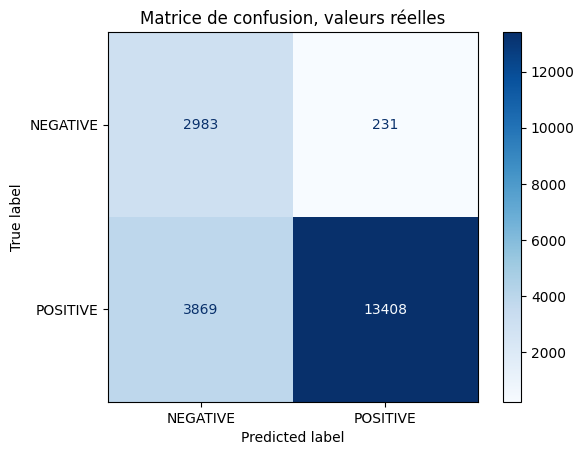

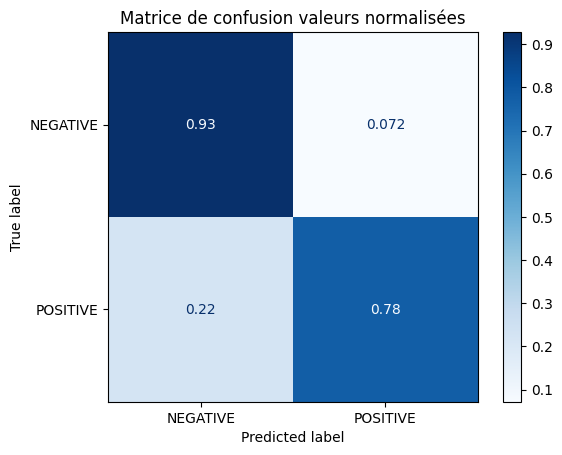

In [56]:
# Premier estimateur

conf_matrix = confusion_matrix(reviews["real_sentiment"], reviews["sentiment_label"])

titles_options = [
    ("Matrice de confusion, valeurs réelles", None),
    ("Matrice de confusion valeurs normalisées", "true"),
]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_predictions(
        y_true=reviews["real_sentiment"],
        y_pred=reviews["sentiment_label"],
        display_labels=["NEGATIVE", "POSITIVE"],
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

plt.show()

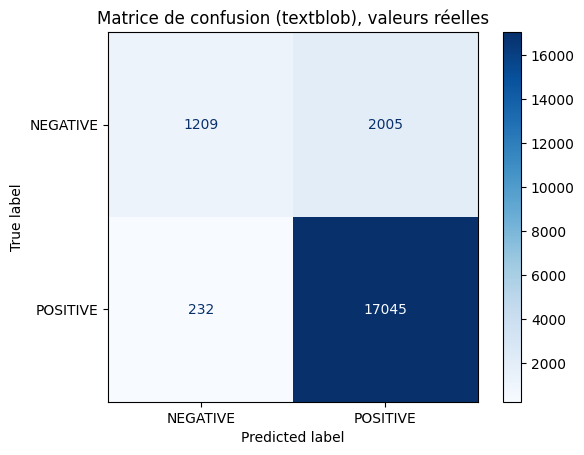

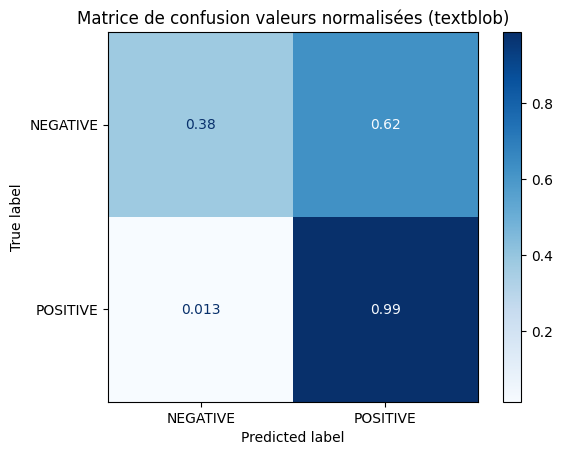

In [58]:
# Estimateur Textblob

conf_matrix = confusion_matrix(reviews["real_sentiment"], reviews["textblob_sentiment_label"])

titles_options = [
    ("Matrice de confusion (textblob), valeurs réelles", None),
    ("Matrice de confusion valeurs normalisées (textblob)", "true"),
]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_predictions(
        y_true=reviews["real_sentiment"],
        y_pred=reviews["textblob_sentiment_label"],
        display_labels=["NEGATIVE", "POSITIVE"],
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

plt.show()

On constate que les deux prédictions sont assez complémentaires avec un modèle qui est très doué pour prédire les avis positifs et l'un qui est très doué pour prédire les avis positifs. Néanmoins, on ne sait pas si ce constat est généralisable à d'autres jeux de données. Utiliser un modèle pour prédire les notres négatives et l'autre pour prédire les notes positives serait une fuite de données (car on utiliserait une information à laquelle on n'est pas censé avoir accès avant la fin du problème).

In [42]:
# Dernier élément à évaluer : pour notre modèle qui prédit des notes est-ce que les notes prédites sont pertinentes ?
fig = px.histogram(reviews, x="difference_from_rating", histnorm='percent', text_auto=True, title = "Différence en pourcentage entre les notes réelles et celles estimées par deep learning (valeur absolue)")
fig.show()
print(f"En regardant la figure, on constate que {round(len(reviews.loc[reviews['difference_from_rating'] <=1]) / len(reviews) * 100, 1)} % des valeurs prédites par le modèle n'ont qu'un point d'écart avec la vraie note.")

En regardant la figure, on constate que 85.3 % des valeurs prédites par le modèle n'ont qu'un point d'écart avec la vraie note.


In [15]:
# Question 4)
# Temps d'execution long (1 heure environ).
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
embedding_data = embedding_model.encode(reviews["Review"].apply(lambda x : x[-1024:]).to_numpy())

In [16]:
# Afin d'éviter d'avoir à relancer l'opération à chaque fois. On enregistre les résultats sur disque dur.
with open("data/embeddings.pkl", "wb") as fOut:
    pickle.dump({"sentences": reviews["Review"].to_numpy(), "embeddings": embedding_data}, fOut, protocol=pickle.HIGHEST_PROTOCOL)

In [2]:
obj = pd.read_pickle('data/embeddings.pkl')

In [4]:
# Le traitement étant long, on enregistre le résultat
reviews = pd.read_csv("data/data_with_stars.csv", sep=";")

In [5]:
# Question 5) Deep Learning.
# Nous allons utiliser tensorflow

np.random.seed(42)
#reviews["rating_norm"] = (reviews["Rating"] - reviews["Rating"].mean()) / reviews["Rating"].std()
X_train, X_test, y_train, y_test = train_test_split(obj["embeddings"], reviews["Rating"], test_size=0.2)

In [8]:
nodes=64
dropout_rate=0.1
model = Sequential()# Constuire un modèle ici
model.add(Dense(64, activation="relu", input_shape=(X_train.shape[1], 1)))
model.add(Dropout(dropout_rate))
model.add(Dense(1, activation="relu"))
model.add(Flatten())
model.add(Dense(1, activation="relu"))
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 384, 64)        │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 384, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 384, 1)         │            65 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           385 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 578 (2.26 KB)

 Trainable params: 578 (2.26 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# Nous construisons ensuite notre algorithme de machine learning. 
# Pour ce faire, nous construisons notre modèle et nous enfilons les couches les unes sur les autres.
# Ce modèle plus gros possède de moins bonnes performances que le précédent.
# Comme quoi, la taille n'est pas le principal.

np.random.seed(42)
nodes = 128
dropout_rate = 0.2 # Set the dropout rate

model = Sequential()
model.add(Dense(nodes, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(MaxPooling1D(X_train.shape[1]//nodes))
model.add(Dropout(dropout_rate))
model.add(Dense(nodes, activation='relu'))
model.add(MaxPooling1D())
model.add(Dropout(dropout_rate))
model.add(Dense(nodes//2, activation='relu'))
model.add(MaxPooling1D())
model.add(Dropout(dropout_rate))
model.add(Dense(nodes//4, activation='relu'))
model.add(Dropout(dropout_rate))
model.add(Flatten())
model.add(Dense(1, activation='relu'))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 384, 128)       │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 128, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128, 128)       │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 64, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64, 64)         │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 32, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32, 32)         │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,129 (109.88 KB)

 Trainable params: 28,129 (109.88 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model.compile(loss='mae', optimizer='adam', metrics=[MeanSquaredError])

# Nous lançons notre entrainement.
model.fit(x=np.asarray(X_train).astype('float32'), y=np.asarray(y_train).astype('float32'), epochs=100, batch_size=16, callbacks=[early_stopping], validation_split=0.2)

Epoch 1/100


820/820 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 1.3578 - mean_squared_error: 3.5058 - val_loss: 0.9131 - val_mean_squared_error: 1.4366
Epoch 2/100
820/820 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.8504 - mean_squared_error: 1.2679 - val_loss: 0.6680 - val_mean_squared_error: 0.7344
Epoch 3/100
820/820 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.6753 - mean_squared_error: 0.7409 - val_loss: 0.6405 - val_mean_squared_error: 0.6724
Epoch 4/100
820/820 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.6550 - mean_squared_error: 0.7002 - val_loss: 0.6276 - val_mean_squared_error: 0.6605
Epoch 5/100
820/820 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.6404 - mean_squared_error: 0.6793 - val_loss: 0.6281 - val_mean_squared_error: 0.6472
Epoch 6/100
820/820 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.6335 - mean_squared_error: 0.6706 - val_loss: 0.6224 - val_mean_squared_error: 0.6420
Epoch 7/100
820/820 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.6281 - mean_squared_error: 0.6521 - val_loss: 0.6317 - 

In [10]:
array_predict = model.predict(np.asarray(X_test).astype('float32'))
prediction_df = pd.DataFrame(array_predict, columns = ["Rating"])
error_df = (prediction_df - pd.DataFrame(y_test).reset_index(drop=True)[["Rating"]]).apply(np.round).add_suffix("_error")
test_val_with_error = pd.concat([y_test.reset_index(drop=True), error_df], axis=1)
test_val_with_error["Rating_error_abs"] = test_val_with_error["Rating_error"].apply(abs)

129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [11]:
# Voyons voir si on fait mieux que le modèle préentrainé
fig = px.histogram(test_val_with_error, x="Rating_error_abs", histnorm='percent', text_auto=True, title = "Différence en pourcentage entre les notes réelles et celles estimées par deep learning (valeur absolue)")
fig.show()
print(f"En regardant la figure, on constate que {round(len(test_val_with_error.loc[test_val_with_error['Rating_error_abs'] <=1]) / len(test_val_with_error) * 100, 1)} % des valeurs prédites par le modèle n'ont qu'un point d'écart avec la vraie note.")

En regardant la figure, on constate que 93.4 % des valeurs prédites par le modèle n'ont qu'un point d'écart avec la vraie note.


Piste d'améliorations : essayer de pondérer les valeurs moins représentées.

### Partie 4) Analyse de thèmes
---

1) En utilisant la méthode KMeans trouvez le nombre optimal de cluster dans nos données.
2) Identifiez les thèmes évoqués dans les différents clusters.
2) En utilisant BertTopic, classifiez nos avis par sujets.

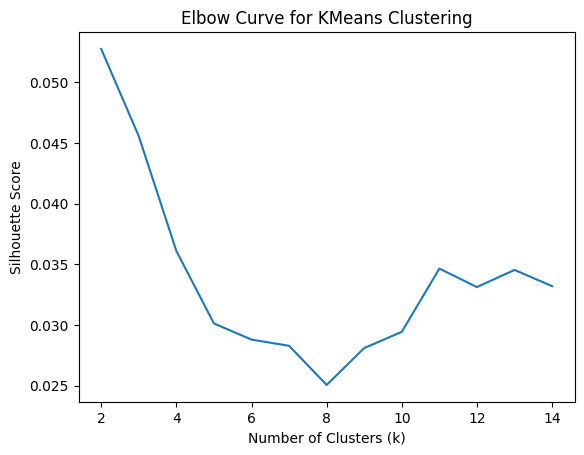

In [61]:
# Question 1) On utilise la méthode KMeans pour classer nos avis.
# Comme on ne connait pas à l'avance le nombre optimal de clusters, on teste pour toutes les valeurs de k entre 2 et 15

k_range = range(2, 15)

# On stocke la compacité de chacun des clusters
silhouette_scores = []

for k in k_range:
  kmeans = KMeans(n_clusters=k, random_state=0)
  kmeans.fit(embedding_data)

  # Une fois le modèle entrainé, on évalue la compacité des clusters
  silhouette = silhouette_score(embedding_data, kmeans.labels_)
  silhouette_scores.append(silhouette)

# On fait une courbe pour visualiser les résultats
plt.plot(k_range, silhouette_scores)
plt.xlabel("Nombre de Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Elbow Curve pour la classification KMeans")
plt.show()


best_k = k_range[silhouette_scores.index(min(silhouette_scores))]
print(f"La meilleure valeur de K semble être {best_k}.")

In [63]:
# Question 2) Une fois nos valeurs classifiées, visualisons les résultats.

kmeans = KMeans(n_clusters=best_k, random_state=0)
kmeans.fit(embedding_data)
reviews["kmeans_label"] = kmeans.labels_

Main words used to talk about hotels in catagory = 0. Nombre d'avis concernés : 880 et note moyenne : 3.7954545454545454


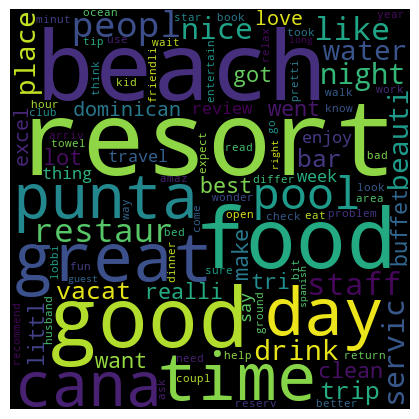

Main words used to talk about hotels in catagory = 1. Nombre d'avis concernés : 3583 et note moyenne : 4.234161317331845


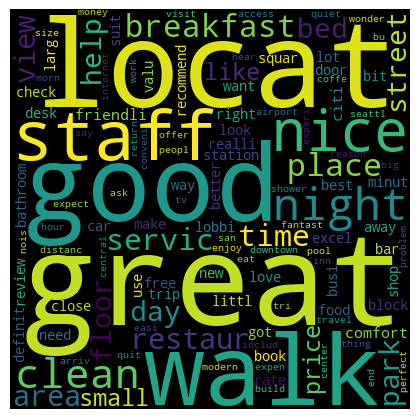

Main words used to talk about hotels in catagory = 2. Nombre d'avis concernés : 2236 et note moyenne : 4.261180679785331


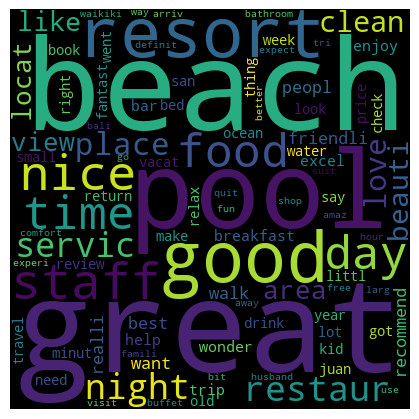

Main words used to talk about hotels in catagory = 3. Nombre d'avis concernés : 4301 et note moyenne : 4.448500348756103


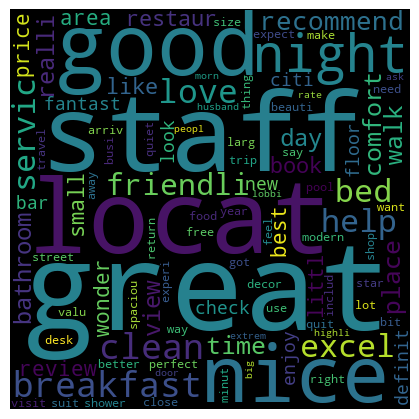

Main words used to talk about hotels in catagory = 4. Nombre d'avis concernés : 3290 et note moyenne : 2.433130699088146


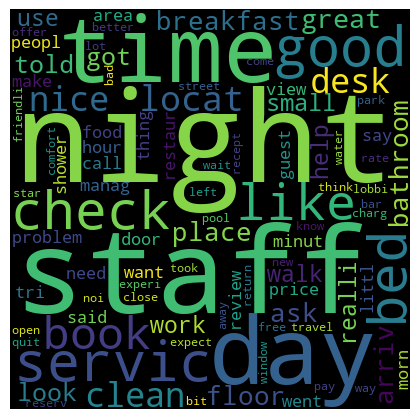

Main words used to talk about hotels in catagory = 5. Nombre d'avis concernés : 1055 et note moyenne : 4.477725118483412


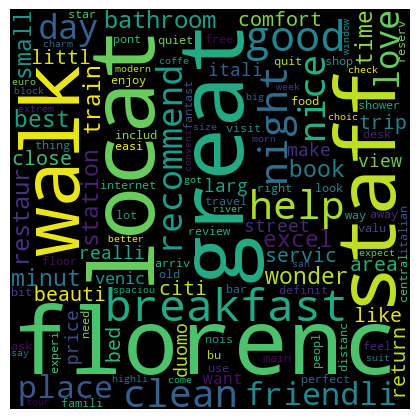

Main words used to talk about hotels in catagory = 6. Nombre d'avis concernés : 3001 et note moyenne : 4.334888370543152


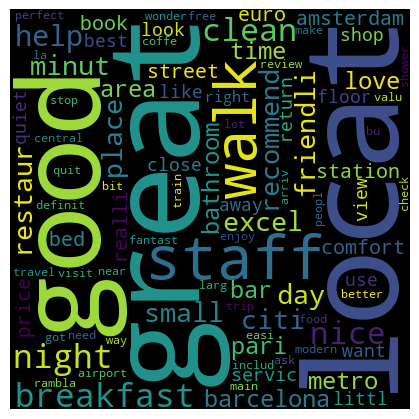

Main words used to talk about hotels in catagory = 7. Nombre d'avis concernés : 2145 et note moyenne : 3.7645687645687644


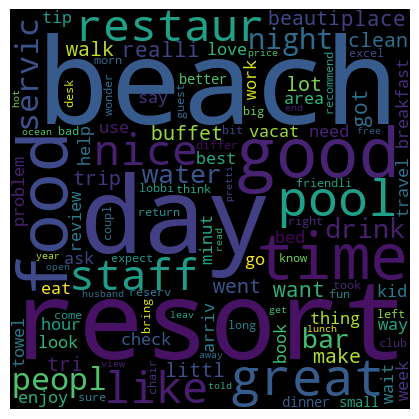

In [69]:
# Mettons en place une étape de stemming
ps = PorterStemmer()

reviews["review_text_no_punkt"] = reviews["Review"].apply(lambda x : x.lower().replace("\n", " ").replace(",", "").replace(".", "").replace("!", "").replace("?", ""))
reviews["review_tokenized"] = reviews["review_text_no_punkt"].apply(word_tokenize)
# Note : Nous utilisons une liste de stopwords auquelle nous ajoutons quelques mots en plus.
stop_words = set(stopwords.words('english') + ["n't", "hotel", "room", "stay"])
reviews["review_text_stem"] = reviews["review_tokenized"].apply(lambda x : " ".join([ps.stem(word) for word in x if len(word) < 100 and word.lower() not in stop_words]))

# Même chose que tout à l'heure

for k in range(best_k):
    study_group = reviews.loc[reviews["kmeans_label"] == k]
    review_text = " ".join(study_group["review_text_stem"].values)

    # Wordcloud
    wordcloud = WordCloud(width = 400, height = 400,
                background_color ='black',
                stopwords = stop_words,
                min_font_size = 10,
                collocations=False).generate(review_text)
    
    print(f"Main words used to talk about hotels in catagory = {k}. Nombre d'avis concernés : {len(study_group)} et note moyenne : {study_group['Rating'].mean()}")
    plt.figure(figsize = (4, 4), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    
    plt.show()

In [71]:
# Question 3) Bertopic.
# Bertopic peut utiliser plusieurs manières de représenter les textes. Par défaut, il utilise Tf-Idf. Dans notre cas, nous allons garder cela tel quel

# Initialisation
topic_model = BERTopic()
topics, probs = topic_model.fit_transform(reviews['Review'])
topic_model.get_topic_info()

Topic  Count                               Name  \
0       -1   6470                 -1_not_room_nt_did   
1        0   1405        0_location_great_hotel_good   
2        1   1029          1_punta_cana_resort_beach   
3        2    860    2_barcelona_ramblas_hotel_metro   
4        3    777       3_amsterdam_hotel_canal_tram   
..     ...    ...                                ...   
102    101     11   101_hyatt_nice_fantastic_surfing   
103    102     11  102_home_clarendon_evergreen_away   
104    103     10           103_mns_street_rambla_la   
105    104     10      104_noise_hear_shame_airplane   
106    105     10      105_shower_yuo_hortus_sprayer   

                                        Representation  \
0    [not, room, nt, did, hotel, no, good, great, s...   
1    [location, great, hotel, good, clean, staff, n...   
2    [punta, cana, resort, beach, food, not, people...   
3    [barcelona, ramblas, hotel, metro, city, catal...   
4    [amsterdam, hotel, canal, tram, room, dam, loc...   
..                                                 ...   
102  [hyatt, nice, fantastic, surfing, walkable, st...   
103  [home, clarendon, evergreen, away, business, b...   
104  [mns, street, rambla, la, metro, location, bus...   
105  [noise, hear, shame, airplane, soundproofing, ...   
106  [shower, yuo, hortus, sprayer, not, design, no...   

                                   Representative_Docs  
0    [liked spent 6 year anniversary secrets excell...  
1    [recommended stayed hotel 3 times, excellent l...  
2    [honest review visit 5/21-5/28 let begin sayin...  
3    [average stayed hotel october 14-16 2004. room...  
4    [fantastic place stay just returned great 4 ni...  
..                                                 ...  
102  [believe hype, weeklong stay peninsula palace ...  
103  [home away home, hotel albion knows make guest...  
104  [great location lovely rooms just returned fiv...  
105  [not bad price given central downtown location...  
106  [strange experience location center nice hotel...  

[107 rows x 5 columns]

In [72]:
# Le topic -1 représente les outliers. Nous en avons pas mal.
topic_model.get_topic(-1)

[('not', 0.00815500952759128),
 ('room', 0.00806105364454725),
 ('nt', 0.007048067399180801),
 ('did', 0.006845452141725307),
 ('hotel', 0.00674137982351012),
 ('no', 0.006405961089859996),
 ('good', 0.006037978157758493),
 ('great', 0.005891997946530364),
 ('staff', 0.005834210629434929),
 ('service', 0.0057780052400280635)]

In [73]:
topic_model.get_topic_info(-1)

Topic  Count                Name  \
0     -1   6470  -1_not_room_nt_did   

                                      Representation  \
0  [not, room, nt, did, hotel, no, good, great, s...   

                                 Representative_Docs  
0  [liked spent 6 year anniversary secrets excell...